In [1]:
# Add all the necessary packages
using Pkg
Pkg.add("ImageSegmentation")
Pkg.add("Images")
Pkg.add("QuartzImageIO")
Pkg.add("ImageMagick")
Pkg.add("ImageView")
Pkg.add("Gtk")
Pkg.add("Plots")
Pkg.add("Statistics")
Pkg.add("Distributed")

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.0/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.0/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.ju

In [2]:
using QuartzImageIO, Images, ImageSegmentation, ImageMagick, Distributed

# This encodes a minimal version of the watershed algorithm, for proof-of-concept. We did not wish to 
# use the entire marker-based watershed algorithm for performance testing, since it would have been 
# prohibitively time-consuming on large data sets; however, this pared-down version provides enough
# functionality to still shed light on the merits of parallelization.

@everywhere function water(img)
    cells = img[:,:,1]
    farr = convert(Array{Float64},channelview(cells))
    thresh_cells = .09000
    mask = farr .< thresh_cells
    farr[mask] .= 0
    mask2 = farr .>= thresh_cells
    farr[mask2] .= 1
    Gray.(farr)
    bw_cells = Gray.(cells) .> thresh_cells;
    dist_cells = distance_transform(feature_transform(bw_cells));
    markers = label_components(dist_cells .< 2);
    segments = watershed(dist_cells, markers)
    seg_arr = labels_map(segments)
    Gray.(seg_arr./maximum(seg_arr))
    seg_arr = labels_map(segments)
    mask = farr .== 0.0
    seg_arr[mask] .= 0
    seg_arr = seg_arr./maximum(seg_arr).*1 # normalize so no values will be greater than 255
    Gray.(seg_arr)
end

In [8]:
# Serial Julia execution

function serial(img)
    images = Array[] 
    # We populate the array with multiple copies of the same image for simplicity's sake
    for i = 1:1000 
        push!(images, img)
    end

    for i in images
        water(i)
    end
end

serial (generic function with 1 method)

In [9]:
# Run the serialized Julia code

img = load("/Users/oliviawaring/Dropbox (MIT)/6.338_Project/gray.png")
@time serial(img)

606.220252 seconds (344.09 k allocations: 110.615 GiB, 5.91% gc time)


In [ ]:
# Multi-threading parallelization approach

using Base.Threads
@show nthreads()
Threads.nthreads()

function multithreaded(img)
    images = Array[] 
    # We populate the array with multiple copies of the same image for simplicity's sake
    for i = 1:1000 
       push!(images, img)
    end

    @threads for i in images
        water(i)
    end
end

#Results: 

#p=1
#n=100
#60.108251 seconds (4.96 M allocations: 11.293 GiB, 6.03% gc time)
#56.538706 seconds (32.61 k allocations: 11.061 GiB, 6.01% gc time)
#55.525238 seconds (32.61 k allocations: 11.061 GiB, 5.82% gc time)
#55.839830 seconds (32.61 k allocations: 11.061 GiB, 5.97% gc time)
#59.074202 seconds (32.61 k allocations: 11.061 GiB, 5.93% gc time)
#57.083783 seconds (32.61 k allocations: 11.061 GiB, 6.10% gc time)
#57.473758 seconds (32.61 k allocations: 11.061 GiB, 5.82% gc time)
#56.676688 seconds (32.61 k allocations: 11.061 GiB, 6.03% gc time)
#55.542341 seconds (32.61 k allocations: 11.061 GiB, 6.05% gc time)
#54.653670 seconds (32.61 k allocations: 11.061 GiB, 5.99% gc time)

#p=1
#n=1000
#576.273894 seconds (350.45 k allocations: 110.616 GiB, 6.01% gc time)
#575.209737 seconds (326.01 k allocations: 110.615 GiB, 5.97% gc time)
#564.259141 seconds (326.01 k allocations: 110.615 GiB, 5.89% gc time)
#570.471746 seconds (326.01 k allocations: 110.615 GiB, 5.92% gc time)
#552.264370 seconds (326.01 k allocations: 110.615 GiB, 5.85% gc time)
#544.408482 seconds (326.01 k allocations: 110.615 GiB, 5.75% gc time)
#597.573260 seconds (326.01 k allocations: 110.615 GiB, 5.45% gc time)
#567.488539 seconds (326.01 k allocations: 110.615 GiB, 5.52% gc time)
#868.272086 seconds (326.01 k allocations: 110.615 GiB, 4.93% gc time)
#754.235159 seconds (326.01 k allocations: 110.615 GiB, 5.05% gc time)

#p=2
#n=100
#48.890179 seconds (5.02 M allocations: 11.296 GiB, 13.38% gc time)
#45.944086 seconds (32.61 k allocations: 11.061 GiB, 13.88% gc time)
#41.924961 seconds (32.60 k allocations: 11.061 GiB, 14.60% gc time)
#43.289116 seconds (32.61 k allocations: 11.061 GiB, 13.37% gc time)
#43.394537 seconds (32.61 k allocations: 11.061 GiB, 13.69% gc time)
#46.110321 seconds (32.61 k allocations: 11.061 GiB, 13.46% gc time)
#43.433423 seconds (32.61 k allocations: 11.061 GiB, 14.55% gc time)
#38.864350 seconds (32.61 k allocations: 11.061 GiB, 14.22% gc time)
#38.997952 seconds (32.61 k allocations: 11.061 GiB, 13.83% gc time)
#39.809057 seconds (32.61 k allocations: 11.061 GiB, 13.96% gc time)

#p=2
#n=1000
#412.320666 seconds (350.44 k allocations: 110.616 GiB, 13.65% gc time)
#446.509128 seconds (326.01 k allocations: 110.615 GiB, 13.78% gc time)
#384.095195 seconds (326.00 k allocations: 110.614 GiB, 14.02% gc time)
#390.988272 seconds (326.00 k allocations: 110.615 GiB, 13.90% gc time)
#394.205761 seconds (326.00 k allocations: 110.595 GiB, 13.72% gc time)
#386.571802 seconds (326.00 k allocations: 110.615 GiB, 13.79% gc time)
#406.991631 seconds (326.00 k allocations: 110.614 GiB, 13.72% gc time)
#398.383348 seconds (325.99 k allocations: 110.614 GiB, 13.84% gc time)
#411.713187 seconds (326.00 k allocations: 110.615 GiB, 13.75% gc time)
#396.277033 seconds (326.00 k allocations: 110.614 GiB, 14.10% gc time)

#p=4
#n=100
#45.654785 seconds (495.89 k allocations: 11.040 GiB, 15.08% gc time)
#34.257212 seconds (32.59 k allocations: 11.060 GiB, 14.24% gc time)
#35.953565 seconds (32.60 k allocations: 11.045 GiB, 16.61% gc time)
#40.857360 seconds (32.60 k allocations: 11.027 GiB, 15.49% gc time)
#33.695085 seconds (32.60 k allocations: 11.052 GiB, 13.24% gc time)
#36.180907 seconds (32.60 k allocations: 11.022 GiB, 14.26% gc time)
#37.322197 seconds (32.60 k allocations: 11.051 GiB, 11.91% gc time)
#32.485988 seconds (32.60 k allocations: 11.061 GiB, 10.38% gc time)
#33.806433 seconds (32.60 k allocations: 11.052 GiB, 13.18% gc time)
#28.553843 seconds (32.60 k allocations: 11.036 GiB, 11.39% gc time)

#p=4
#n=1000
#329.153271 seconds (350.36 k allocations: 110.515 GiB, 12.59% gc time)
#343.527397 seconds (325.94 k allocations: 110.527 GiB, 13.11% gc time)
#336.996577 seconds (325.95 k allocations: 110.535 GiB, 11.23% gc time)
#347.865393 seconds (325.97 k allocations: 110.552 GiB, 9.98% gc time)
#295.905954 seconds (325.97 k allocations: 110.545 GiB, 9.78% gc time)
#294.906123 seconds (325.97 k allocations: 110.587 GiB, 9.51% gc time)
#310.320317 seconds (325.98 k allocations: 110.586 GiB, 10.33% gc time)
#329.856429 seconds (325.97 k allocations: 110.550 GiB, 9.73% gc time)
#379.370616 seconds (325.99 k allocations: 110.560 GiB, 9.80% gc time)
#319.350808 seconds (325.96 k allocations: 110.565 GiB, 9.34% gc time)

In [ ]:
# Run 10 tests of the multithreaded parallelization approach

img = load("/Users/oliviawaring/Dropbox (MIT)/6.338_Project/gray.png")

for j=1:10
   @time multithreaded(img)
end

In [3]:
# Distributed parallelization approach

using Distributed

function distributed(img)
    images = Array[] 
    # We populate the array with multiple copies of the same image for simplicity's sake
    for i = 1:100
        push!(images, img)
    end
        
    W = workers()
    # Assign different workers to each image (this example works for the p=4 case)
    for i=1:1000
        if i%2 == 0
            p = W[1]
        elseif i%2 == 1
            p = W[2]
        elseif i%4 == 2
            p = W[3]
        else 
            p = W[4]
        end
        @spawnat p water(images[i])
    end 
end

#Results:

#n = 100
#p=2
#0.601317 seconds (16.02 k allocations: 489.859 KiB)
#0.618335 seconds (15.59 k allocations: 473.969 KiB)
#0.664955 seconds (15.60 k allocations: 474.063 KiB)
#0.609873 seconds (15.58 k allocations: 473.656 KiB)
#0.671941 seconds (17.69 k allocations: 543.031 KiB)
#0.643956 seconds (15.66 k allocations: 475.109 KiB)
#0.714267 seconds (15.67 k allocations: 475.547 KiB)
#0.669496 seconds (15.67 k allocations: 475.609 KiB)
#0.634889 seconds (15.67 k allocations: 475.219 KiB)

#p=4
#0.721006 seconds (15.87 k allocations: 486.203 KiB)
#0.672569 seconds (15.88 k allocations: 486.391 KiB)
#0.642752 seconds (15.88 k allocations: 486.328 KiB)
#0.653228 seconds (15.87 k allocations: 486.141 KiB)
#0.664858 seconds (15.88 k allocations: 486.750 KiB)
#0.768902 seconds (15.88 k allocations: 486.750 KiB)
#0.915208 seconds (15.87 k allocations: 486.266 KiB)
#0.716007 seconds (15.88 k allocations: 486.328 KiB)
#0.637853 seconds (15.88 k allocations: 486.422 KiB)

#n = 1000
#p = 2
#7.613602 seconds (2.67 M allocations: 106.078 MiB, 0.45% gc time)
#6.067003 seconds (1.06 M allocations: 24.635 MiB, 0.11% gc time)
#6.945089 seconds (1.06 M allocations: 24.659 MiB, 0.09% gc time)
#6.599281 seconds (1.06 M allocations: 24.673 MiB, 0.08% gc time)
#7.179466 seconds (1.07 M allocations: 24.722 MiB, 0.06% gc time)
#7.370191 seconds (1.06 M allocations: 24.660 MiB, 0.11% gc time)
#6.728969 seconds (1.06 M allocations: 24.450 MiB, 0.08% gc time)
#6.744966 seconds (1.08 M allocations: 25.161 MiB, 0.12% gc time)
#6.597403 seconds (1.06 M allocations: 24.659 MiB, 0.07% gc time)
#7.082993 seconds (1.06 M allocations: 24.659 MiB, 0.07% gc time)

#p = 4
#8.919983 seconds (2.67 M allocations: 105.935 MiB, 0.53% gc time)
#6.737250 seconds (1.07 M allocations: 24.697 MiB, 0.14% gc time)
#6.783031 seconds (1.06 M allocations: 24.659 MiB, 0.09% gc time)
#6.936681 seconds (1.06 M allocations: 24.659 MiB, 0.09% gc time)
#6.438594 seconds (1.07 M allocations: 24.951 MiB, 0.18% gc time)
#6.705186 seconds (1.06 M allocations: 24.659 MiB, 0.10% gc time)
#7.002310 seconds (1.06 M allocations: 24.659 MiB, 0.11% gc time)
#6.573457 seconds (1.07 M allocations: 24.675 MiB, 0.09% gc time)
#6.267999 seconds (1.07 M allocations: 24.720 MiB, 0.08% gc time)
#7.377481 seconds (1.06 M allocations: 24.660 MiB, 0.08% gc time)

#p = 8
#6.216522 seconds (1.06 M allocations: 24.662 MiB, 0.22% gc time)
#6.437376 seconds (1.07 M allocations: 24.741 MiB, 0.08% gc time)
#5.845668 seconds (1.06 M allocations: 24.673 MiB, 0.06% gc time)
#6.279350 seconds (1.06 M allocations: 24.673 MiB, 0.05% gc time)
#6.426406 seconds (1.07 M allocations: 24.755 MiB, 0.12% gc time)
#5.812271 seconds (1.06 M allocations: 24.672 MiB, 0.08% gc time)
#5.818070 seconds (1.07 M allocations: 24.882 MiB, 0.15% gc time)
#6.678738 seconds (1.07 M allocations: 24.690 MiB, 0.09% gc time)
#6.313483 seconds (1.07 M allocations: 24.732 MiB, 0.06% gc time)
#6.272526 seconds (1.06 M allocations: 24.672 MiB, 0.09% gc time)

1


distributed (generic function with 1 method)

In [5]:
# Run 10 tests of the multithreaded parallelization approach
img = load("/Users/oliviawaring/Dropbox (MIT)/6.338_Project/gray.png")

addprocs(1) # Use this command to add workers
for j=1:10
   @time distributed(img)
end

2
  1.818317 seconds (1.36 M allocations: 68.202 MiB, 0.95% gc time)
2
  0.601317 seconds (16.02 k allocations: 489.859 KiB)
2
  0.618335 seconds (15.59 k allocations: 473.969 KiB)
2
  0.664955 seconds (15.60 k allocations: 474.063 KiB)
2
  0.609873 seconds (15.58 k allocations: 473.656 KiB)
2
  0.671941 seconds (17.69 k allocations: 543.031 KiB)
2
  0.643956 seconds (15.66 k allocations: 475.109 KiB)
2
  0.714267 seconds (15.67 k allocations: 475.547 KiB)
2
  0.669496 seconds (15.67 k allocations: 475.609 KiB)
2
  0.634889 seconds (15.67 k allocations: 475.219 KiB)


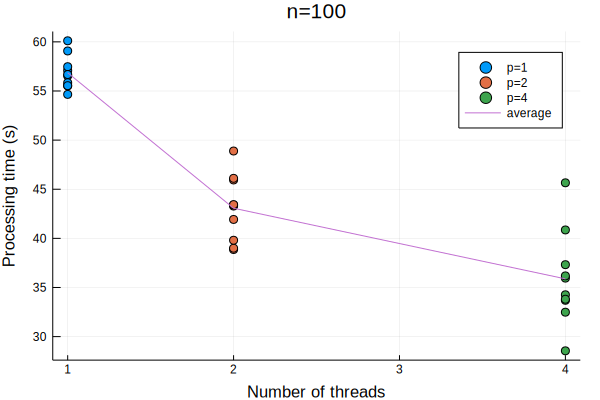

In [4]:
# Display data for n=100, multi-threaded

using Plots, Statistics

time_p1n100 = [60.108251, 56.538706, 55.525238, 55.839830, 59.074202, 57.083783, 57.473758, 56.676688, 55.542341, 54.653670]
time_p2n100 = [48.890179, 45.944086, 41.924961, 43.289116, 43.394537, 46.110321, 43.433423, 38.864350, 38.997952, 39.809057]
time_p4n100 = [45.654785, 34.257212, 35.953565, 40.857360, 33.695085, 36.180907, 37.322197, 32.485988, 33.806433, 28.553843]

a = [1 for n in 1:10]
b = [2 for n in 1:10]
c = [4 for n in 1:10]
d = [1,2,4]

avg100 = [mean(time_p1n100), mean(time_p2n100), mean(time_p4n100)]

gr() # Set the backend to GR
scatter!(a,time_p1n100, lab="p=1") 
scatter!(b,time_p2n100,lab="p=2") 
scatter!(c,time_p4n100,lab="p=4") 
plot!(d, avg100, lab="average")
title!("n=100")
yaxis!("Processing time (s)")
xaxis!("Number of threads")


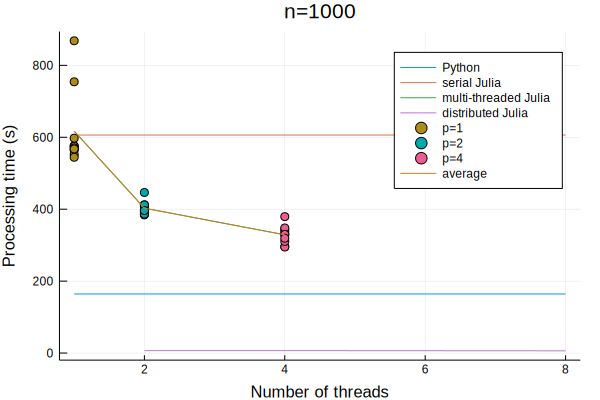

In [3]:
# Display data for n=1000, multi-threaded

using Plots, Statistics

time_p1n1000 = [576.273894, 575.209737, 564.259141, 570.471746,  552.264370, 544.408482, 597.573260, 567.488539, 868.272086, 754.235159]
time_p2n1000 = [412.320666, 446.509128, 384.095195, 390.988272, 394.205761, 386.571802, 406.991631, 398.383348, 411.713187, 396.277033]
time_p4n1000 = [329.153271, 343.527397, 336.996577, 347.865393, 295.905954, 294.906123, 310.320317, 329.856429, 379.370616, 319.350808]

a = [1 for n in 1:10]
b = [2 for n in 1:10]
c = [4 for n in 1:10]
d = [1,2,4]

gr() # Set the backend to GR
scatter!(a,time_p1n1000, lab="p=1") 
scatter!(b,time_p2n1000,lab="p=2") 
scatter!(c,time_p4n1000,lab="p=4") 
avg1000_thread = [mean(time_p1n1000), mean(time_p2n1000), mean(time_p4n1000)]
plot!(d, avg1000_thread, lab="average")
title!("n=1000")
yaxis!("Processing time (s)")
xaxis!("Number of threads")

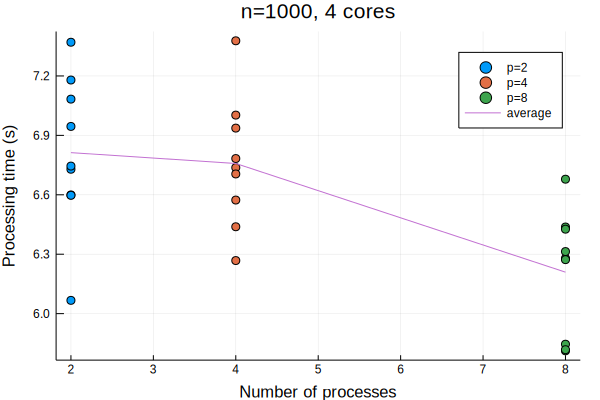

In [2]:
# Display data for n=1000, distributed

using Plots, Statistics

time_nprocs21000 = [6.067003, 6.945089, 6.599281, 7.179466, 7.370191, 6.728969, 6.744966, 6.597403, 7.082993]
time_nprocs41000 = [6.737250, 6.783031, 6.936681, 6.438594, 6.705180, 7.002310, 6.573457, 6.267999, 7.377481]
time_nprocs81000 = [6.437376, 5.845668, 6.279350, 6.426406, 5.812271, 5.818070, 6.678738, 6.313483, 6.272526]

a = [2 for n in 1:9]
b = [4 for n in 1:9]
c = [8 for n in 1:9]
d = [2,4,8]

gr() # Set the backend to GR
scatter!(a,time_nprocs21000,lab="p=2") 
scatter!(b,time_nprocs41000,lab="p=4") 
scatter!(c,time_nprocs81000,lab="p=8") 
avg1000_dist = [mean(time_nprocs21000), mean(time_nprocs41000), mean(time_nprocs81000)]
plot!(d, avg1000_dist, lab="average")
title!("n=1000, 4 cores")
yaxis!("Processing time (s)")
xaxis!("Number of processes")

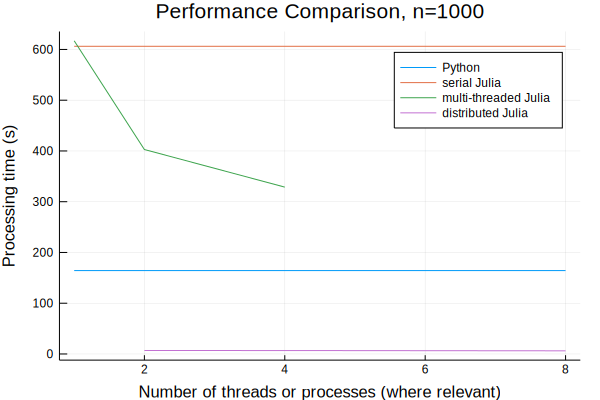

In [2]:
#Comparing the python code vs. the serial Julia code vs. parallelized Julia code

using Plots, Statistics

python = [164.3, 164.3, 164.3, 164.3]
cereal = [606.220252, 606.220252, 606.220252, 606.220252]
a = [1,2,4,8]
b = [2,4,8]
c = [1,2,4]

time_p1n1000 = [576.273894, 575.209737, 564.259141, 570.471746,  552.264370, 544.408482, 597.573260, 567.488539, 868.272086, 754.235159]
time_p2n1000 = [412.320666, 446.509128, 384.095195, 390.988272, 394.205761, 386.571802, 406.991631, 398.383348, 411.713187, 396.277033]
time_p4n1000 = [329.153271, 343.527397, 336.996577, 347.865393, 295.905954, 294.906123, 310.320317, 329.856429, 379.370616, 319.350808]
avg1000_thread = [mean(time_p1n1000), mean(time_p2n1000), mean(time_p4n1000)]

time_nprocs21000 = [6.067003, 6.945089, 6.599281, 7.179466, 7.370191, 6.728969, 6.744966, 6.597403, 7.082993]
time_nprocs41000 = [6.737250, 6.783031, 6.936681, 6.438594, 6.705180, 7.002310, 6.573457, 6.267999, 7.377481]
time_nprocs81000 = [6.437376, 5.845668, 6.279350, 6.426406, 5.812271, 5.818070, 6.678738, 6.313483, 6.272526]
avg1000_dist = [mean(time_nprocs21000), mean(time_nprocs41000), mean(time_nprocs81000)]

gr() # Set the backend to GR
plot!(a, python, lab="Python")
plot!(a, cereal, lab="serial Julia")
plot!(c, avg1000_thread, lab="multi-threaded Julia")
plot!(b, avg1000_dist, lab="distributed Julia")
title!("Performance Comparison, n=1000")
yaxis!("Processing time (s)")
xaxis!("Number of threads or processes (where relevant)")